https://docs.opencv.org/4.5.0/d3/dc0/group__imgproc__shape.html

# Crater Detection & Identification

## Imports & Data

In [36]:
%config InlineBackend.figure_format = 'svg'

In [37]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import cv2
from torchvision import transforms
import torch
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as LA
import pandas as pd
from scipy.spatial.distance import cdist
from itertools import combinations, permutations, repeat
import sklearn.neighbors
import h5py
from dataclasses import dataclass

from craterdetection.detection import DeepMoon

try:
    from VPU import OpenVINOHandler
except ImportError as e:
    print(f"OpenVINO variables not set up -> {e}")

torch.cuda.get_device_name(0)

OpenVINO variables not set up -> No module named 'VPU'


'GeForce RTX 3080'

In [38]:
# sd_input_images = np.load('../blobs/sd_input_images.npy').transpose(0, 3, 1, 2)
# sd_target_masks = np.load('../blobs/sd_target_masks.npy')
h5_craters = h5py.File(r"..\data\dev_craters.hdf5", "r")
h5_images = h5py.File(r"..\data\dev_images.hdf5", "r")

## Setup Model

In [39]:
net = DeepMoon()
checkpoint_path = '../blobs/DeepMoon.pth'
checkpoint = torch.load(checkpoint_path)
net.load_state_dict(checkpoint)
net.eval()

try:
    exp = OpenVINOHandler('DeepMoon', device='MYRIAD', root='../VPU/IR/')
except NameError:
    print("OpenVINOHandler could not be instantiated. See import cell above for more details.")

OpenVINOHandler could not be instantiated. See import cell above for more details.


## Output Post-Processing

### Crater Detection
Utilises thresholding + contour finding + ellipse fitting to return discrete crater detections with ellipticity < 0.1.

In [40]:
from craterdetection.detection.post_processing import crater_detection, draw_detections

### Test Crater Detection Pipeline

In [41]:
image_i = 30
crater_test = h5_craters[f'img_{image_i:05}/block0_values'][...]
df_target = pd.DataFrame(crater_test, columns=['diam', 'lat', 'long', 'x_pix', 'y_pix', 'diam_pix'])
img_test = h5_images['input_images'][image_i]/255
df_target.eval('kmperpix = diam / diam_pix', inplace=True)

target_mask = np.zeros_like(img_test)
for i, r in df_target.iterrows():
    center_coordinates = (round(r['x_pix']), round(r['y_pix']))
    axes_length = (round(r['diam_pix']/2), round(r['diam_pix']/2))
    angle = 0
    target_mask = cv2.ellipse(target_mask, center_coordinates, axes_length, 
               angle, 0, 360, (255, 255, 255), 1)

In [42]:
%%time
batch = img_test.reshape(1, 1, 256, 256)
try:
    out = exp.infer(batch)
except NameError:
    print("OpenVINOHandler is not available. Using PyTorch for inference...")
    with torch.no_grad():
        out = net(torch.Tensor(batch))
        out = out.numpy()

OpenVINOHandler is not available. Using PyTorch for inference...
Wall time: 424 ms


24 craters detected!
Wall time: 81 ms


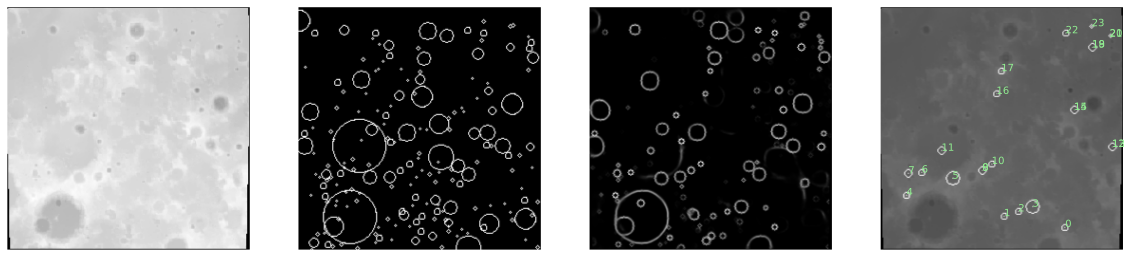

In [43]:
%%time
df_detections = crater_detection(out[0, 0], threshold_lower=80)

img_out = [
    batch[0, 0],
    target_mask,
    out[0, 0],
    255*batch[0, 0]+draw_detections(df_detections)
]

fig, axes = plt.subplots(1, len(img_out), figsize=(20, 15))

for ax, img in zip(axes, img_out):
    ax.imshow(img, cmap='Greys_r')
    ax.axis('off')
    
for index, r in df_detections.iterrows():
    axes[-1].text(r['x_pix'], r['y_pix'], str(index), color='lightgreen')

print(f"{len(df_detections)} craters detected!")
# df_detections

In [44]:
df_detections.head(5)

,x_pix,y_pix,a_pix,b_pix,angle_pix,e,r_pix,diam_pix
0,194.5,231.5,2.549510,2.549510,0.0,0.0,2.549510,5.099020
1,130.0,220.0,2.920516,2.920516,0.0,0.0,2.920516,5.841032
2,145.0,215.0,2.920516,2.920516,0.0,0.0,2.920516,5.841032
3,160.0,210.0,6.812494,6.812494,0.0,0.0,6.812494,13.624988
4,27.0,198.0,2.920516,2.920516,0.0,0.0,2.920516,5.841032


# Crater Matching

From [_Lunar Crater Identification from Digital Images_, J. Christian et al.](http://arxiv.org/abs/2009.01228):

Projective invariants for triads of coplanar conics:

Consider the determinant of a _net_ of three conics:

$$ |\lambda A_i + \mu A_j + \sigma A_k| = \Theta_1\lambda^3 + \Theta_2\lambda^2\mu + \Theta_3\lambda\mu^2 + \Theta_4\mu^3 + \Theta_5\lambda^2\sigma + \Theta_6\lambda\sigma^2 + \Theta_7\sigma^3 + \Theta_8\mu^2\sigma + \Theta_9\mu\sigma^2 + \Theta_{10}\lambda\mu\sigma $$

with $$|A_i| = |A_j| = |A_k| = 1$$

using $$ \left(\sqrt[^n]{\frac{1}{|A|}}\right) A = A'$$

results in

$$ I_{ij} = Tr[A_i^{-1}A_j] $$
$$ I_{ji} = Tr[A_j^{-1}A_i] $$
$$ I_{ik} = Tr[A_i^{-1}A_k] $$
$$ I_{ki} = Tr[A_k^{-1}A_i] $$
$$ I_{jk} = Tr[A_j^{-1}A_k] $$
$$ I_{kj} = Tr[A_k^{-1}A_j] $$
$$ I_{ijk} = Tr{[(A_j + A_k)^* - (A_j - A_k)^*]A_i}$$

In [45]:
from craterdetection.matching import CoplanarInvariants, CraterDatabase
from craterdetection.matching.utils import cyclic_permutations

x_pix, y_pix, a_pix, b_pix, psi_pix, e, r, d = df_detections.to_numpy().T
crater_match_id = df_detections.index.to_numpy()

In [46]:
detection_invariants = CoplanarInvariants.from_detection(x_pix, y_pix, a_pix, b_pix, psi_pix)

In [47]:
%%time
db = CraterDatabase.from_file("../data/lunar_crater_database_robbins_2018.csv")

Wall time: 1min 18s


In [48]:
id_i, id_j, id_k, db_features = db.get_features()

In [49]:
i = 500
sample = detection_invariants.get_pattern()[i]
sample_id = detection_invariants.crater_triads[i]
sample_id

array([ 4,  2, 13])

In [50]:
for o in cyclic_permutations([0, 1, 2]):
    o2 = list(map(lambda x: x+3, o))
    order = o + o2 + [6]
    top_n = np.argpartition(np.sum(np.abs((db_features - sample[order])/sample[order]), axis=1), -5)[-5:]
    print(top_n)

[3248556 3248608 3248569 1814603 1823958]
[3248604 1814491 1823877 1823958 1814603]
[1823877 1814491 3248604 1823958 1814603]


In [32]:
xy_target = df_target[['x_pix', 'y_pix']].to_numpy()
df_matched = df_target.iloc[np.argmin(cdist(df_detections[['x_pix', 'y_pix']].to_numpy(), xy_target), axis=1)]
df_matched.columns = [s+"_t" for s in df_matched.columns]
df_matched = pd.concat([df_detections, df_matched.reset_index(drop=True)], axis=1)

df_matched.iloc[sample_id]

,x_pix,y_pix,a_pix,b_pix,angle_pix,e,r_pix,diam_pix,diam_t,lat_t,long_t,x_pix_t,y_pix_t,diam_pix_t,kmperpix_t
4,27.0,198.0,2.920516,2.920516,0.0,0.0,2.920516,5.841032,13.516697,-9.435347,1.877503,27.601537,198.602681,5.685741,2.377298
2,145.0,215.0,2.920516,2.920516,0.0,0.0,2.920516,5.841032,13.530772,-10.790327,11.227828,145.617314,215.415483,5.691661,2.377298
13,244.0,147.0,3.760699,3.760699,0.0,0.0,3.760699,7.521398,20.979940,-5.413889,18.941350,243.948629,147.317085,8.825121,2.377298


In [53]:
db.get_position(top_n[0, 0])

AttributeError: 'CraterDatabase' object has no attribute 'get_position'

In [ ]:
img_matched = np.zeros_like(batch[0, 0])
for index, r in df_matched.iterrows():
    center_coordinates = (round(r['x_pix_t']), round(r['y_pix_t']))
    axes_length = (round(r['diam_pix_t']/2), round(r['diam_pix_t']/2))
    angle = 0
    img_matched = cv2.ellipse(img_matched, center_coordinates, axes_length, 
               angle, 0, 360, (255, 255, 255), 1)

img_out = [
    255*batch[0, 0]+img_matched,
    255*batch[0, 0]+draw_detections(df_detections)
]

fig, axes = plt.subplots(1, len(img_out), figsize=(15, 15))

for ax, img in zip(axes, img_out):
    ax.imshow(img, cmap='Greys_r')
    ax.axis('off')
    for index, r in df_detections.iterrows():
        ax.text(r['x_pix'], r['y_pix'], str(index), color='lightgreen')

In [55]:
pole_crater = df_matched.iloc[0]
lat_t, long_t = map(np.radians, (df_matched['lat_t'].to_numpy(), df_matched['long_t'].to_numpy()))
lat_pole, long_pole = map(np.radians, (pole_crater['lat_t'], pole_crater['long_t']))

dlat = lat_t - lat_pole
dlong = long_t - long_pole
R = 1737.1

x_t = 2*R*np.arcsin(np.cos(lat_pole)*np.sin(dlong/2))
y_t = R*dlat

a_t, b_t = [df_matched['diam_t'].to_numpy()/2]*2
phi_t = 0.

matched_craters = crater_representation(x_t, y_t, a_t, b_t, phi_t)
ci_t = CoplanarInvariants(matched_craters)

In [65]:
(ci[0] - ci_t[:])

array([[-2.04903789e+02, -2.04903789e+02, -2.04903789e+02, ...,
         1.05175991e+03, -4.88711282e+02,  1.31344924e+03],
       [-1.60429093e+02, -1.60429093e+02, -1.60429093e+02, ...,
         5.69338690e+02, -4.12595220e+02,  2.87113023e+03],
       [-1.03515431e+02, -3.22306061e+02, -2.87973340e+02, ...,
        -2.03153520e+02, -2.03153520e+02, -1.97270492e+02],
       ...,
       [-3.96003011e+00,  3.23853285e+02,  2.21624076e+01, ...,
         1.55971131e+02,  5.44797769e+02,  5.44797769e+02],
       [-1.01011723e+00,  4.23987512e+02,  2.41989302e+00, ...,
         9.71775354e+01,  1.89684546e+02,  1.89684546e+02],
       [-1.38172007e+12, -1.38172007e+12, -1.38172007e+12, ...,
        -1.38172007e+12, -1.38172007e+12, -1.38172007e+12]])

CraterTriad(I_ij=-502.7791183339331, I_ji=-270.3043207596711, I_ik=-2111.343560139649, I_ki=-1417.8198171491342, I_jk=-125.67100001075613, I_kj=-156.9267954251939, I_ijk=12.986424423546634, indices=(0, 19, 29))

In [ ]:
def latlong2cartesian(lat, long, alt=0, rad=1737.1):
    """
    Calculate Cartesian coordinates from latitude + longitude information
    """
    lat, long = np.deg2rad(lat), np.deg2rad(long)
    f  = 1./825.                                # flattening (Moon)
    ls = np.arctan((1 - f)**2 * np.tan(lat))    # lambda

    x = rad * np.cos(ls) * np.cos(long) + alt * np.cos(lat) * np.cos(long)
    y = rad * np.cos(ls) * np.sin(long) + alt * np.cos(lat) * np.sin(long)
    z = rad * np.sin(ls) + alt * np.sin(lat)

    return x, y, z

def haversine_np(lat1, long1, lat2, long2):
    """
    Calculate the great circle distance between two points
    on the Moon (specified in decimal degrees)

    All args must be of equal length.    

    """
    long1, lat1, long2, lat2 = map(np.radians, [long1, lat1, long2, lat2])

    dlong = long2 - long1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlong/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 1737.1 * c
    return km

## Crater Database

In [28]:
def load_craters(source='DeepMoon', latlims=None, longlims=None, diamlims=None):
    if source == 'DeepMoon':

        LROC = pd.read_csv('../data/LROCCraters.csv', usecols=list(range(2,5)))
        LROC.columns = ['diam', 'long', 'lat']

        Head = pd.read_csv('../data/HeadCraters.csv')
        Head.columns = ['long', 'lat', 'diam']
        Head = Head[LROC.columns]
        df_craters = pd.concat([LROC, Head])
        df_craters = df_craters[['lat', 'long', 'diam']]
        df_craters.reset_index(inplace=True, drop=True)
        
    elif source == 'Robbins':
        df_craters = pd.read_csv("../data/lunar_crater_database_robbins_2018.csv", usecols=['LAT_CIRC_IMG', 'LON_CIRC_IMG', 'DIAM_CIRC_IMG'])
        df_craters.columns = ['lat', 'long', 'diam'] 
        
    else:
        raise ValueError("No such source exists!")
        
    if latlims:
        lat0, lat1 = latlims
        df_craters.query('(lat > @lat0) & (lat < @lat1)', inplace=True)
    if longlims:
        long0, long1 = longlims
        df_craters.query('(long > @long0) & (long < @long1)', inplace=True)
    if diamlims:
        diam0, diam1 = diamlims
        df_craters.query('(diam > @diam0) & (diam < @diam1)', inplace=True)

    return df_craters

### Create Database Abstraction

In [29]:
class CraterDatabase:
    def __init__(self,
                 source_id: np.ndarray,
                 dest_id: np.ndarray,
                 dist: np.ndarray,
                 source_diam: np.ndarray,
                 dest_diam: np.ndarray,
                 normalised: bool
                 ):
        self.source_id = source_id
        self.dest_id = dest_id
        self.dist = dist
        self.source_diam = source_diam
        self.dest_diam = dest_diam
        self._normalised = normalised

    def is_normalised(self):
        return self._normalised

    @classmethod
    def from_df(cls, df, radius=300, normalise=True, keys={'lat': 'lat', 'long': 'long', 'diam': 'diam'}):
        lat, long = df[[keys['lat'], keys['long']]].to_numpy().T
        x, y, z = latlong2cartesian(lat, long)
        diam = df[keys['diam']].to_numpy()

        A = sklearn.neighbors.radius_neighbors_graph(np.array([x, y, z]).T, radius, mode='connectivity', metric='euclidean', n_jobs=-1)
        source_id, dest_id = A.nonzero()
        dist = haversine_np(lat[source_id], long[source_id], lat[dest_id], long[dest_id])

        if normalise:
            dist /= diam[source_id]

        return cls(source_id, dest_id, dist, diam[source_id], diam[dest_id], normalised=normalise)

    def __repr__(self):
        n = 'normalised' if self._normalised else 'absolute'
        return self.__class__.__name__+f"( ({len(np.unique(self.source_id))}x{len(np.unique(self.dest_id))}) <-> {len(self.dist)} [{n}] )"

In [31]:
df_craters = load_craters(latlims=(-80, 0), longlims=(0, 50))
    
crater_db = CraterDatabase.from_df(df_craters, radius=300)
crater_db

CraterDatabase( (1863x1863) <-> 376730 [normalised] )

## Mask Information

In [32]:
test_xyz = latlong2cartesian(df_target['lat'].to_numpy(), df_target['long'].to_numpy())
df_target[['x_MCMF', 'y_MCMF', 'z_MCMF']] = np.array(test_xyz).T
kmperpix = df_target.iloc[0]['kmperpix'] # cheats
df_target.describe()

,diam,lat,long,x_pix,y_pix,diam_pix,kmperpix,x_MCMF,y_MCMF,z_MCMF
count,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,3.900000e+01,39.000000,39.000000,39.000000
mean,37.822614,-26.565873,-18.144212,134.852545,157.879503,24.065482,1.571654e+00,1470.298354,-481.936286,-773.475426
std,132.300817,4.131940,3.749339,64.686623,79.816469,84.179344,5.293895e-16,59.654608,97.974497,112.774771
min,5.119097,-31.461804,-25.075700,14.473853,4.519815,3.257140,1.571654e+00,1347.391872,-675.848998,-905.044859
25%,6.690081,-30.131539,-21.840001,71.711449,86.025105,4.256713,1.571654e+00,1432.806260,-569.614215,-870.419679
50%,9.800990,-27.980840,-17.290996,150.980734,186.996020,6.236098,1.571654e+00,1464.119884,-469.947942,-813.464961
75%,19.680354,-22.861217,-15.359690,185.619045,225.997263,12.522064,1.571654e+00,1502.025727,-411.956658,-673.472592
max,835.450433,-18.628892,-12.124255,237.686297,253.184163,531.573961,1.571654e+00,1587.588639,-322.370158,-553.686708


## Detections

### Pole Crater Extraction

In [33]:
class CraterSet:
    """
    Set of craters in pixel space
    """
    def __init__(self,
                 x: np.ndarray,
                 y: np.ndarray,
                 diam: np.ndarray,
                 id: np.ndarray):
        self.x = x
        self.y = y
        self.diam = diam
        self.id = id

    @classmethod
    def from_df(cls, df, keys={'x': 'x', 'y': 'y', 'diam': 'diam'}):
        x = df[keys['x']].to_numpy()
        y = df[keys['y']].to_numpy()
        diam = df[keys['diam']].to_numpy()
        id = np.array(df.index)
        return cls(x, y, diam, id)

    def to_array(self):
        return np.array((self.x, self.y, self.diam))

    def to_df(self, keys={'x': 'x', 'y': 'y', 'diam': 'diam'}):
        return pd.DataFrame(
            {
                keys['x']: self.x,
                keys['y']: self.y,
                keys['diam']: self.diam
            },
            index=self.id
        )

    def xy(self):
        return self.to_array()[:2]

    def slice(self, i):
        return CraterSet(self.x[i], self.y[i], self.diam[i], self.id[i])

    def __getitem__(self, i):
        return self.x[i], self.y[i], self.diam[i]

    def __len__(self):
        return len(self.x)

    def __repr__(self):
        return self.__class__.__name__+f"({len(self)})"

    def __iter__(self):
        for x, y, diam, id in zip(self.x, self.y, self.diam, self.id):
            yield x, y, diam, id


class AdjacentCraters:
    def __init__(self,
                 craters: CraterSet,
                 dist: np.ndarray,
                 normalised: bool
                 ):
        self.craters = craters
        self.dist = dist
        self._normalised = normalised

    def is_normalised(self):
        return self._normalised
    
    def iter_adj(self):
        for dist, (_, _, diam, id) in zip(self.dist, self.craters):
            yield dist, id, diam

    def __repr__(self):
        n = 'normalised' if self._normalised else 'absolute'
        return self.__class__.__name__+f"( craters={repr(self.craters)}, dist=ndarray{self.dist.shape} [{n}] )"


class PoleCrater:
    def __init__(self,
                 x: np.float64,
                 y: np.float64,
                 diam: np.float64,
                 index: int,
                 adj: AdjacentCraters,
                 ):
        self.x = x
        self.y = y
        self.diam = diam
        self.index = index
        self.adj = adj

    def is_normalised(self):
        return self.adj.is_normalised()

    @classmethod
    def from_craterset(cls,
                       craterset,
                       offset=0,
                       pixel_space=np.array([[256, 256]]),
                       normalise=True,
                       kmperpix=None
                       ):
        if offset > (len(craterset) - 1):
            raise KeyError(f"Offset ({offset}) out of bounds! Cannot be higher than {(len(craterset) - 1)}.")

        center = pixel_space // 2

        index = np.argsort(cdist(center, craterset.xy().T, 'euclidean')).squeeze()[offset]
        x, y, diam = craterset[index]

        adj_craters = craterset.slice(craterset.id != index)
        adj_dist = cdist(np.array([[x, y]]), adj_craters.xy().T, 'euclidean').squeeze()

        if normalise:
            adj_dist /= diam
        elif kmperpix:
            adj_dist *= kmperpix
            adj_craters.diam *= kmperpix
        else:
            raise ValueError("normalise=False requires kmperpix kwarg to be defined!")
            

        adj = AdjacentCraters(adj_craters, adj_dist, normalised=normalise)

        return cls(x, y, diam, index, adj)
    
    def iter_adj(self):
        return self.adj.iter_adj()
        

    def to_img(self, img=None, shape=(256, 256)):
        if not img:
            img = np.zeros(shape)

        for x_adj, y_adj, _, _ in self.adj.craters:
            cv2.line(img, (round(self.x), round(self.y)), (round(x_adj), round(y_adj)), (255, 1, 0), 1)

        return img

    def __repr__(self):
        return self.__class__.__name__+f"( x={self.x:.2f}, y={self.y:.2f}, diam={self.diam:.2f}, index={self.index}, adj={repr(self.adj)} )"


In [34]:
keys = {
    'x': 'x_pix',
    'y': 'y_pix',
    'diam': 'diam_pix'
}

cd = CraterSet.from_df(df_detections, keys)
cd

CraterSet(16)

In [37]:
pc_list = {i: PoleCrater.from_craterset(cd, offset=i) for i in range(len(cd))}
pc = pc_list[0]
pc

PoleCrater( x=162.16, y=84.06, diam=19.30, index=11, adj=AdjacentCraters( craters=CraterSet(15), dist=ndarray(15,) [normalised] ) )

In [39]:
df_matched.eval('diam_err = (diam_pix_t - diam_pix)/diam_pix_t', inplace=True)
df_matched.eval('x_err = (x_pix_t - x_pix)/x_pix_t', inplace=True)
df_matched.eval('y_err = (y_pix_t - y_pix)/y_pix_t', inplace=True)

### Acceptance Phase

In [40]:
keys = {
    'x': 'x_pix',
    'y': 'y_pix',
    'diam': 'diam_pix'
}

crater_db = CraterDatabase.from_df(df_craters, normalise=False, radius=300)
cd = CraterSet.from_df(df_detections, keys=keys)
pc = PoleCrater.from_craterset(cd, offset=9, normalise=False, kmperpix=kmperpix)
assert crater_db.is_normalised() is pc.is_normalised()

err_diam = 0.01
err_dist = 0.0

In [41]:
candidates = np.int(0)

for dist, id, diam_dest in pc.iter_adj():
    # Filter world data based on detected normalised pair distance
    mask_dist = np.bitwise_and(crater_db.dist > dist*(1-err_dist-err_diam), crater_db.dist < dist*(1+err_dist+err_diam))

    candidates = np.append(candidates, crater_db.source_id[mask_dist])
    
candidates, occurrence = np.unique(candidates, return_counts=True)
order = np.argsort(-occurrence)

prime_candidate = candidates[order[0]]

candidates[order[:10]], occurrence[order[:10]]

(array([ 417,  491,  739,  647,  472,  690,  430,  471, 1517,  767]),
 array([74, 70, 65, 65, 64, 63, 62, 62, 62, 62], dtype=int64))

In [42]:
df_craters.iloc[prime_candidate]

lat    -38.365327
long    20.445428
diam     5.609870
Name: 6719, dtype: float64

In [43]:
df_matched.iloc[pc.index][['lat_t', 'long_t', 'diam_t']], pc.diam

(lat_t    -24.211311
 long_t   -24.708316
 diam_t    23.425695
 Name: 9, dtype: float64, 14.959289073944092)

### [OLD]

In [87]:
%%time

# TODO: kmperpix
# TODO: switch to multi-poles

closest_order = np.argsort(theta)

err_dist = 0.3

diam_det = df_detections.iloc[pole_index].r_pix*2*kmperpix
err_diam = 2

unique_list = []
counts_list = []

diam_row, diam_col = diam[row], diam[col]
mask_diam = np.bitwise_and(diam_row > diam_det-err_diam, diam_row < diam_det+err_diam)
row_f, col_f = row[mask_diam], col[mask_diam]
data_f = data[mask_diam]
diam_row, diam_col = diam_row[row_f], diam_col[col_f]

for theta_ij, (index, det) in zip(theta[closest_order]*kmperpix, df_detections.iloc[closest_order].iterrows()):
    diam_j = det.r_pix * 2 * kmperpix
    mask_diam_col = np.bitwise_and(diam_col > diam_j-err_diam, diam_col < diam_j+err_diam)
    
    row_ff, col_ff = row_f[mask_diam_col], col_f[mask_diam_col]
    data_ff = data_f[mask_diam_col]
    # Filter world data based on detected pair distance
    mask_dist = np.bitwise_and(data_ff > theta_ij-err_dist, data_ff < theta_ij+err_dist)

    row_fff, col_fff = row_ff[mask_dist], col_ff[mask_dist]
    data_fff = data_ff[mask_dist]

    unique, counts = np.unique(row_fff, return_counts=True)
    unique_list.append(unique)
    counts_list.append(counts)
    
candidates = {}
for u, c in zip(unique_list, counts_list):
    for ui, ci, in zip(u, c):
        if ui not in candidates.keys():
            candidates[ui] = ci
        else:
            candidates[ui] += ci
print(f"({max(candidates, key=candidates.get)}: {max(candidates.values())})")

prime_candidate = max(candidates, key=candidates.get)

df_craters.iloc[prime_candidate]

NameError: name 'theta' is not defined

## Cython Test

In [547]:
%load_ext Cython

In [548]:
%%cython
cdef void mandel_single_point(double complex *z_in, 
                              double complex *c_in,
                              double complex *z_out) nogil:
    #
    # The Mandelbrot iteration
    #

    #
    # Some points of note:
    #
    # - It's *NOT* allowed to call any Python functions here.
    #
    #   The Ufunc loop runs with the Python Global Interpreter Lock released.
    #   Hence, the ``nogil``.
    #
    # - And so all local variables must be declared with ``cdef``
    #
    # - Note also that this function receives *pointers* to the data;
    #   the "traditional" solution to passing complex variables around
    #

    cdef double complex z = z_in[0]
    cdef double complex c = c_in[0]
    cdef int k  # the integer we use in the for loop

    # Straightforward iteration

    for k in range(100):
        z = z*z + c
        if z.real**2 + z.imag**2 > 1000:
            break

    # Return the answer for this point
    z_out[0] = z

# SpaceEngine test

10 craters detected!


,x,y,a,b,angle,e
0,134.430832,204.430832,2.358139,2.485638,135.000000,0.051294
1,163.500000,172.500000,2.549510,2.549510,0.000000,0.000000
2,67.500000,161.500000,2.549510,2.549510,0.000000,0.000000
3,211.730469,146.500000,2.551301,2.792993,90.000000,0.086535
4,44.500000,126.500000,2.549510,2.549510,0.000000,0.000000
5,221.500000,109.500000,2.549510,2.549510,0.000000,0.000000
6,210.940247,107.000000,2.028463,2.117456,0.000000,0.042028
7,174.952332,36.933552,2.974316,3.056455,112.231094,0.026874
8,113.741692,25.998363,3.925573,3.994529,175.959106,0.017263
9,216.500000,8.500000,1.581139,1.581139,0.000000,0.000000


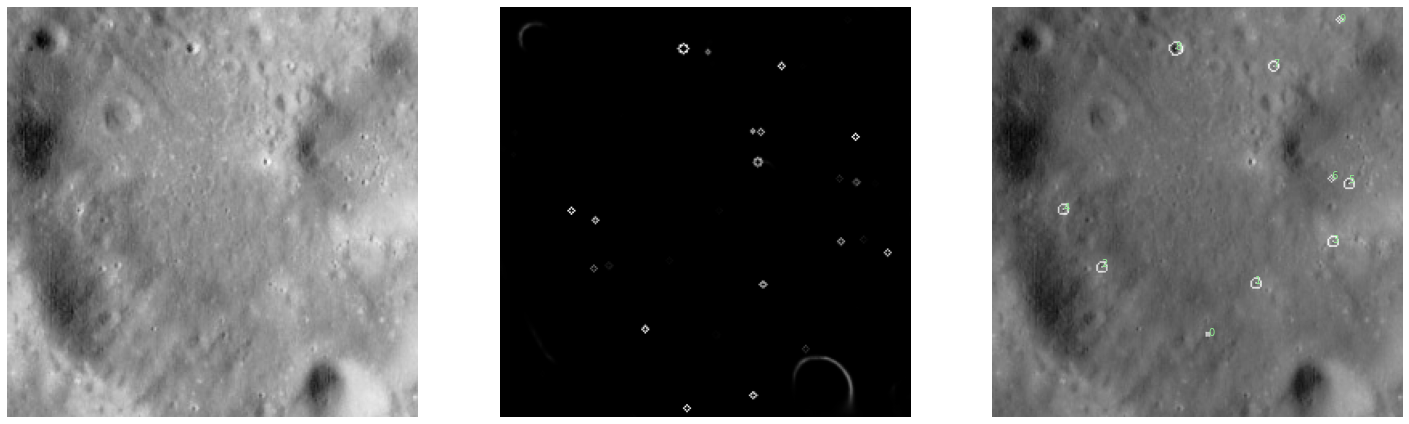

In [120]:
# Image metadata
img = cv2.imread('../data/scr00020.jpg', cv2.IMREAD_GRAYSCALE)
lat, long = (-78.40696667, -42.517858) #scr00003
h = 86.52 #km
fov = 45 #degrees (vertical FOV uncropped image)

# Crop center of screenshot to input shape 
ysize, xsize = img.shape
_, _, x_in, y_in = exp.input_shape
img = img[(ysize//2)-(y_in//2):(ysize//2)+(y_in//2), (xsize//2)-(x_in//2):(xsize//2)+(x_in//2)]

# Image dimension
d = 2*(y_in/ysize)*h*np.tan(np.deg2rad(fov/2)) 
fov_crop = np.rad2deg(np.arctan(d/h))
batch = transforms.ToTensor()(img.copy()).unsqueeze_(0)
out = exp.infer(batch)

# Plot 
df_detections = crater_detection(out[0, 0], threshold_lower=1)

img_out = [
    batch[0, 0],
    out[0, 0],
    700*batch[0, 0]+draw_detections(df_detections)
]

fig, axes = plt.subplots(1, len(img_out), figsize=(25, 15))

for ax, img in zip(axes, img_out):
    ax.imshow(img, cmap='Greys_r')
    ax.axis('off')
    
for i, r in df_detections.iterrows():
    axes[-1].text(r['x'], r['y'], str(i), color='lightgreen')

print(f"{len(df_detections)} craters detected!")
df_detections